# High School Timetabling: Goal Programming

This notebook extends the database-integrated timetabling model with **goal programming** for teacher preferences. Teachers can express soft constraints like "I want Tuesdays off" or "I want to teach Math on Monday Period 1", prioritized by seniority.

## What's New

- **Teacher Preferences**: DAY_OFF and SPECIFIC_TIME preferences
- **Priority Levels**: Senior teachers (15+ years) get Priority 1, mid-level (7-14) get Priority 2, junior (0-6) get Priority 3
- **Goal Programming**: Soft constraints via `.as_goal(priority, weight)`
- **Goal Satisfaction Analysis**: Track which preferences were achieved

## Mathematical Formulation

**Hard Constraints** (must be satisfied):
- Each lecture assigned exactly once
- No room/teacher/class conflicts
- Classroom capacity constraints

**Soft Constraints (Goals)** (minimize violations):
- DAY_OFF: $\sum_{t \in day, r} x_{l,t,r} \leq 0$ for teacher's lectures on preferred day
- SPECIFIC_TIME: $\sum_{r} x_{l,t,r} = 1$ for specific lecture at specific timeslot

**Priority Ordering**: Priority 1 goals satisfied first, then Priority 2, then Priority 3.

## 1. Setup and Imports

In [1]:
# Standard library
from typing import Tuple, Dict, List
from enum import Enum

# Database
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, Session

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# LumiX
from lumix import LXConstraint, LXLinearExpression, LXModel, LXOptimizer, LXVariable
from lumix.indexing import LXIndexDimension

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

Base = declarative_base()

## 2. Define ORM Models

We extend the database model with:
- `work_years` field on Teacher (for seniority)
- `TeacherPreference` table (for DAY_OFF and SPECIFIC_TIME preferences)

In [2]:
class Teacher(Base):
    """Teacher with seniority."""
    __tablename__ = 'teachers'
    
    id = Column(Integer, primary_key=True)
    name = Column(String(100), nullable=False)
    work_years = Column(Integer, default=0)  # Years of service


class Classroom(Base):
    __tablename__ = 'classrooms'
    id = Column(Integer, primary_key=True)
    name = Column(String(50), nullable=False)
    capacity = Column(Integer, nullable=False)


class SchoolClass(Base):
    __tablename__ = 'school_classes'
    id = Column(Integer, primary_key=True)
    name = Column(String(20), nullable=False)
    size = Column(Integer, nullable=False)


class Subject(Base):
    __tablename__ = 'subjects'
    id = Column(Integer, primary_key=True)
    name = Column(String(50), nullable=False)


class TimeSlot(Base):
    __tablename__ = 'timeslots'
    id = Column(Integer, primary_key=True)
    day_of_week = Column(Integer, nullable=False)
    period = Column(Integer, nullable=False)
    day_name = Column(String(20), nullable=False)


class Lecture(Base):
    __tablename__ = 'lectures'
    id = Column(Integer, primary_key=True)
    subject_id = Column(Integer, ForeignKey('subjects.id'), nullable=False)
    teacher_id = Column(Integer, ForeignKey('teachers.id'), nullable=False)
    class_id = Column(Integer, ForeignKey('school_classes.id'), nullable=False)


class TeacherPreference(Base):
    """Teacher scheduling preferences."""
    __tablename__ = 'teacher_preferences'
    
    id = Column(Integer, primary_key=True)
    teacher_id = Column(Integer, ForeignKey('teachers.id'), nullable=False)
    preference_type = Column(String(20), nullable=False)  # DAY_OFF or SPECIFIC_TIME
    day_of_week = Column(Integer, nullable=True)          # For DAY_OFF
    lecture_id = Column(Integer, nullable=True)           # For SPECIFIC_TIME
    timeslot_id = Column(Integer, nullable=True)          # For SPECIFIC_TIME


class ScheduleAssignment(Base):
    __tablename__ = 'schedule_assignments'
    id = Column(Integer, primary_key=True, autoincrement=True)
    lecture_id = Column(Integer, ForeignKey('lectures.id'), nullable=False)
    timeslot_id = Column(Integer, ForeignKey('timeslots.id'), nullable=False)
    classroom_id = Column(Integer, ForeignKey('classrooms.id'), nullable=False)


def calculate_priority(work_years: int) -> int:
    """Calculate priority from work years.
    
    15+ years -> Priority 1 (highest)
    7-14 years -> Priority 2
    0-6 years -> Priority 3 (lowest)
    """
    if work_years >= 15:
        return 1
    elif work_years >= 7:
        return 2
    else:
        return 3


print("ORM models defined with TeacherPreference")

ORM models defined with TeacherPreference


## 3. Create and Populate Database

In [3]:
# Create in-memory database
engine = create_engine('sqlite:///:memory:', echo=False)
Base.metadata.create_all(engine)
SessionLocal = sessionmaker(bind=engine)
session = SessionLocal()

# Teachers with seniority
teachers_data = [
    Teacher(id=1, name="Dr. Smith", work_years=18),      # Senior (P1)
    Teacher(id=2, name="Prof. Johnson", work_years=12),  # Mid-level (P2)
    Teacher(id=3, name="Ms. Williams", work_years=8),    # Mid-level (P2)
    Teacher(id=4, name="Mr. Brown", work_years=5),       # Junior (P3)
    Teacher(id=5, name="Dr. Davis", work_years=15),      # Senior (P1)
]
session.add_all(teachers_data)

# Classrooms
classrooms_data = [
    Classroom(id=1, name="Room 101", capacity=30),
    Classroom(id=2, name="Room 102", capacity=30),
    Classroom(id=3, name="Room 201", capacity=25),
    Classroom(id=4, name="Lab A", capacity=20),
]
session.add_all(classrooms_data)

# School Classes
classes_data = [
    SchoolClass(id=1, name="9A", size=25),
    SchoolClass(id=2, name="9B", size=28),
    SchoolClass(id=3, name="10A", size=24),
    SchoolClass(id=4, name="10B", size=26),
]
session.add_all(classes_data)

# Subjects
subjects_data = [
    Subject(id=1, name="Math"),
    Subject(id=2, name="English"),
    Subject(id=3, name="Physics"),
    Subject(id=4, name="Chemistry"),
    Subject(id=5, name="History"),
]
session.add_all(subjects_data)

# Timeslots
DAY_NAMES = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
slot_id = 1
for day in range(5):
    for period in range(1, 7):
        session.add(TimeSlot(id=slot_id, day_of_week=day, period=period, day_name=DAY_NAMES[day]))
        slot_id += 1

# Lectures
lectures_data = [
    Lecture(id=1, subject_id=1, teacher_id=1, class_id=1),
    Lecture(id=2, subject_id=1, teacher_id=1, class_id=1),
    Lecture(id=3, subject_id=1, teacher_id=1, class_id=2),
    Lecture(id=4, subject_id=1, teacher_id=1, class_id=2),
    Lecture(id=5, subject_id=2, teacher_id=2, class_id=1),
    Lecture(id=6, subject_id=2, teacher_id=2, class_id=2),
    Lecture(id=7, subject_id=2, teacher_id=2, class_id=3),
    Lecture(id=8, subject_id=3, teacher_id=3, class_id=3),
    Lecture(id=9, subject_id=3, teacher_id=3, class_id=3),
    Lecture(id=10, subject_id=3, teacher_id=3, class_id=4),
    Lecture(id=11, subject_id=3, teacher_id=3, class_id=4),
    Lecture(id=12, subject_id=4, teacher_id=4, class_id=3),
    Lecture(id=13, subject_id=4, teacher_id=4, class_id=4),
    Lecture(id=14, subject_id=5, teacher_id=5, class_id=1),
    Lecture(id=15, subject_id=5, teacher_id=5, class_id=2),
    Lecture(id=16, subject_id=5, teacher_id=5, class_id=3),
    Lecture(id=17, subject_id=5, teacher_id=5, class_id=4),
    Lecture(id=18, subject_id=1, teacher_id=1, class_id=3),
    Lecture(id=19, subject_id=1, teacher_id=1, class_id=4),
    Lecture(id=20, subject_id=2, teacher_id=2, class_id=4),
]
session.add_all(lectures_data)

# Teacher Preferences
preferences_data = [
    # Dr. Smith (18 years, P1): wants Friday off
    TeacherPreference(id=1, teacher_id=1, preference_type="DAY_OFF", day_of_week=4),
    # Prof. Johnson (12 years, P2): wants Tuesday off
    TeacherPreference(id=2, teacher_id=2, preference_type="DAY_OFF", day_of_week=1),
    # Ms. Williams (8 years, P2): wants Physics 10A on Monday Period 1
    TeacherPreference(id=3, teacher_id=3, preference_type="SPECIFIC_TIME", lecture_id=8, timeslot_id=1),
    # Mr. Brown (5 years, P3): wants Wednesday off
    TeacherPreference(id=4, teacher_id=4, preference_type="DAY_OFF", day_of_week=2),
    # Dr. Davis (15 years, P1): wants History 9A on Monday Period 2
    TeacherPreference(id=5, teacher_id=5, preference_type="SPECIFIC_TIME", lecture_id=14, timeslot_id=2),
]
session.add_all(preferences_data)

session.commit()

print("Database populated:")
print(f"  Teachers: {session.query(Teacher).count()}")
print(f"  Preferences: {session.query(TeacherPreference).count()}")

Database populated:
  Teachers: 5
  Preferences: 5


## 4. Visualize Teacher Preferences

In [4]:
# Teacher seniority and priority
teachers_info = []
for t in session.query(Teacher).all():
    priority = calculate_priority(t.work_years)
    teachers_info.append({
        'Teacher': t.name,
        'Years': t.work_years,
        'Priority': priority,
        'Level': 'Senior' if priority == 1 else 'Mid-level' if priority == 2 else 'Junior'
    })

teachers_df = pd.DataFrame(teachers_info).sort_values('Years', ascending=False)
print("Teacher Seniority:")
display(teachers_df.set_index('Teacher'))

Teacher Seniority:


,Years,Priority,Level
Teacher,,,
Dr. Smith,18,1,Senior
Dr. Davis,15,1,Senior
Prof. Johnson,12,2,Mid-level
Ms. Williams,8,2,Mid-level
Mr. Brown,5,3,Junior


In [5]:
# Preferences summary
prefs_info = []
for p in session.query(TeacherPreference).all():
    teacher = session.query(Teacher).filter_by(id=p.teacher_id).first()
    priority = calculate_priority(teacher.work_years)
    
    if p.preference_type == "DAY_OFF":
        desc = f"Wants {DAY_NAMES[p.day_of_week]} off"
    else:
        lecture = session.query(Lecture).filter_by(id=p.lecture_id).first()
        subject = session.query(Subject).filter_by(id=lecture.subject_id).first()
        school_class = session.query(SchoolClass).filter_by(id=lecture.class_id).first()
        ts = session.query(TimeSlot).filter_by(id=p.timeslot_id).first()
        desc = f"{subject.name} {school_class.name} on {ts.day_name} P{ts.period}"
    
    prefs_info.append({
        'Teacher': teacher.name,
        'Priority': f"P{priority}",
        'Type': p.preference_type,
        'Description': desc
    })

prefs_df = pd.DataFrame(prefs_info)
print("Teacher Preferences:")
display(prefs_df)

Teacher Preferences:


,Teacher,Priority,Type,Description
0,Dr. Smith,P1,DAY_OFF,Wants Friday off
1,Prof. Johnson,P2,DAY_OFF,Wants Tuesday off
2,Ms. Williams,P2,SPECIFIC_TIME,Physics 10A on Monday P1
3,Mr. Brown,P3,DAY_OFF,Wants Wednesday off
4,Dr. Davis,P1,SPECIFIC_TIME,History 9A on Monday P2


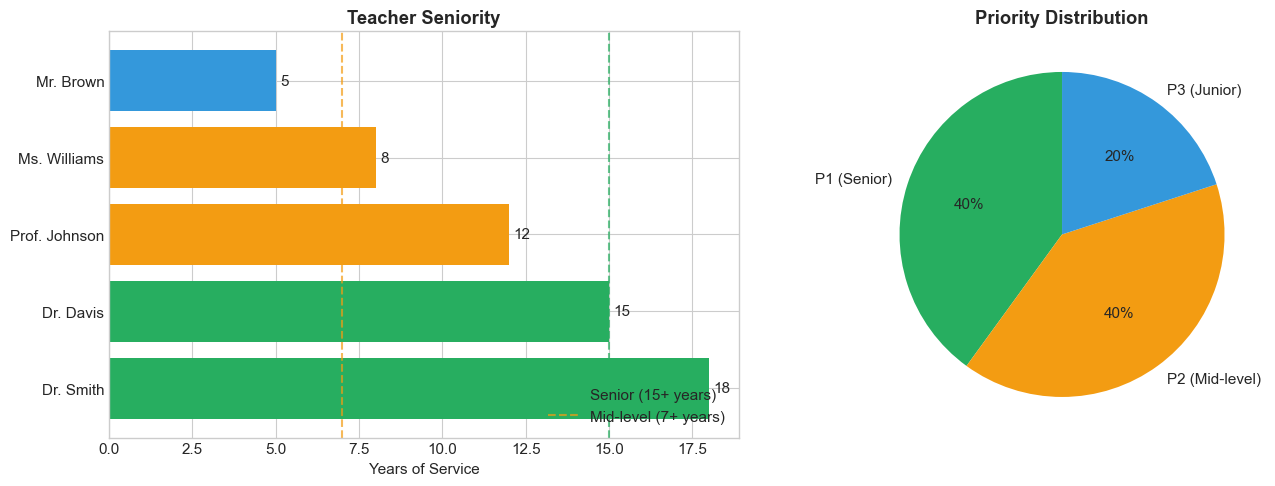

In [6]:
# Visualize seniority and priorities
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Seniority bar chart
ax1 = axes[0]
teachers_sorted = sorted(session.query(Teacher).all(), key=lambda t: t.work_years, reverse=True)
names = [t.name for t in teachers_sorted]
years = [t.work_years for t in teachers_sorted]
colors = ['#27ae60' if calculate_priority(y) == 1 else '#f39c12' if calculate_priority(y) == 2 else '#3498db' for y in years]

bars = ax1.barh(names, years, color=colors)
ax1.axvline(x=15, color='#27ae60', linestyle='--', label='Senior (15+ years)', alpha=0.7)
ax1.axvline(x=7, color='#f39c12', linestyle='--', label='Mid-level (7+ years)', alpha=0.7)
ax1.set_xlabel('Years of Service')
ax1.set_title('Teacher Seniority', fontweight='bold')
ax1.legend(loc='lower right')
ax1.bar_label(bars, padding=3)

# Priority distribution
ax2 = axes[1]
priority_counts = {1: 0, 2: 0, 3: 0}
for t in session.query(Teacher).all():
    p = calculate_priority(t.work_years)
    priority_counts[p] += 1

priorities = list(priority_counts.keys())
counts = list(priority_counts.values())
colors = ['#27ae60', '#f39c12', '#3498db']
labels = ['P1 (Senior)', 'P2 (Mid-level)', 'P3 (Junior)']

ax2.pie(counts, labels=labels, colors=colors, autopct='%1.0f%%', startangle=90)
ax2.set_title('Priority Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Build Model with Goal Programming

In [7]:
def create_cached_fits_checker(session: Session) -> callable:
    class_sizes = {c.id: c.size for c in session.query(SchoolClass).all()}
    room_capacities = {r.id: r.capacity for r in session.query(Classroom).all()}
    
    def check(class_id: int, classroom_id: int) -> bool:
        return class_sizes.get(class_id, 0) <= room_capacities.get(classroom_id, 0)
    
    return check


def build_goal_programming_model(session: Session) -> Tuple[LXModel, LXVariable]:
    """
    Build timetabling model with goal programming for teacher preferences.
    """
    print("Building model with goal programming...")
    
    fits_checker = create_cached_fits_checker(session)
    
    # Decision variable
    assignment = (
        LXVariable[Tuple[Lecture, TimeSlot, Classroom], int]("assignment")
        .binary()
        .indexed_by_product(
            LXIndexDimension(Lecture, lambda lec: lec.id).from_model(session),
            LXIndexDimension(TimeSlot, lambda ts: ts.id).from_model(session),
            LXIndexDimension(Classroom, lambda room: room.id).from_model(session),
        )
        .where_multi(lambda lec, ts, room: fits_checker(lec.class_id, room.id))
    )

    model = LXModel("timetabling_goals").add_variable(assignment)

    # ========== HARD CONSTRAINTS ==========
    print("  Adding hard constraints...")
    
    # Lecture coverage
    for lecture in session.query(Lecture).all():
        expr = LXLinearExpression().add_multi_term(
            assignment,
            coeff=lambda lec, ts, room: 1.0,
            where=lambda lec, ts, room, curr_lec=lecture: lec.id == curr_lec.id,
        )
        model.add_constraint(
            LXConstraint(f"lecture_{lecture.id}_coverage").expression(expr).eq().rhs(1)
        )

    # Room conflicts
    for timeslot in session.query(TimeSlot).all():
        for classroom in session.query(Classroom).all():
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, curr_ts=timeslot, curr_room=classroom:
                    ts.id == curr_ts.id and room.id == curr_room.id,
            )
            model.add_constraint(
                LXConstraint(f"room_{classroom.id}_slot_{timeslot.id}")
                .expression(expr).le().rhs(1)
            )

    # Teacher conflicts
    for teacher in session.query(Teacher).all():
        teacher_lecture_ids = [l.id for l in session.query(Lecture).filter_by(teacher_id=teacher.id).all()]
        for timeslot in session.query(TimeSlot).all():
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, curr_ts=timeslot, t_lecs=teacher_lecture_ids:
                    ts.id == curr_ts.id and lec.id in t_lecs,
            )
            model.add_constraint(
                LXConstraint(f"teacher_{teacher.id}_slot_{timeslot.id}")
                .expression(expr).le().rhs(1)
            )

    # Class conflicts
    for school_class in session.query(SchoolClass).all():
        class_lecture_ids = [l.id for l in session.query(Lecture).filter_by(class_id=school_class.id).all()]
        for timeslot in session.query(TimeSlot).all():
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, curr_ts=timeslot, c_lecs=class_lecture_ids:
                    ts.id == curr_ts.id and lec.id in c_lecs,
            )
            model.add_constraint(
                LXConstraint(f"class_{school_class.id}_slot_{timeslot.id}")
                .expression(expr).le().rhs(1)
            )

    # ========== SOFT CONSTRAINTS (GOALS) ==========
    print("  Adding soft goal constraints...")
    
    for pref in session.query(TeacherPreference).all():
        teacher = session.query(Teacher).filter_by(id=pref.teacher_id).first()
        priority = calculate_priority(teacher.work_years)
        
        if pref.preference_type == "DAY_OFF":
            # Goal: minimize lectures on preferred day off
            teacher_lecture_ids = [l.id for l in session.query(Lecture).filter_by(teacher_id=teacher.id).all()]
            day_timeslot_ids = [ts.id for ts in session.query(TimeSlot).filter_by(day_of_week=pref.day_of_week).all()]
            
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, t_lecs=teacher_lecture_ids, d_slots=day_timeslot_ids:
                    lec.id in t_lecs and ts.id in d_slots,
            )
            
            day_name = DAY_NAMES[pref.day_of_week]
            model.add_constraint(
                LXConstraint(f"goal_day_off_{teacher.id}_{day_name}")
                .expression(expr)
                .le()
                .rhs(0)
                .as_goal(priority=priority, weight=1.0)
            )
            print(f"    [P{priority}] {teacher.name}: {day_name} off")
            
        elif pref.preference_type == "SPECIFIC_TIME":
            # Goal: assign specific lecture to specific timeslot
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, target_lec=pref.lecture_id, target_ts=pref.timeslot_id:
                    lec.id == target_lec and ts.id == target_ts,
            )
            
            model.add_constraint(
                LXConstraint(f"goal_specific_{teacher.id}_lec_{pref.lecture_id}")
                .expression(expr)
                .eq()
                .rhs(1)
                .as_goal(priority=priority, weight=1.0)
            )
            
            lecture = session.query(Lecture).filter_by(id=pref.lecture_id).first()
            subject = session.query(Subject).filter_by(id=lecture.subject_id).first()
            ts = session.query(TimeSlot).filter_by(id=pref.timeslot_id).first()
            print(f"    [P{priority}] {teacher.name}: {subject.name} on {ts.day_name} P{ts.period}")

    # Set goal programming mode
    model.set_goal_mode("weighted")
    
    hard_count = len([c for c in model.constraints if not c.is_goal()])
    soft_count = len([c for c in model.constraints if c.is_goal()])
    print(f"\nModel built: {hard_count} hard constraints, {soft_count} soft goals")
    
    return model, assignment


# Build model
model, assignment = build_goal_programming_model(session)
print("\n" + model.summary())

Building model with goal programming...
  Adding hard constraints...
  Adding soft goal constraints...
    [P1] Dr. Smith: Friday off
    [P2] Prof. Johnson: Tuesday off
    [P2] Ms. Williams: Physics on Monday P1
    [P3] Mr. Brown: Wednesday off
    [P1] Dr. Davis: History on Monday P2

Model built: 410 hard constraints, 5 soft goals

LXModel: timetabling_goals
  Variable Families: 1
  Constraint Families: 415
  Objective: max
  Goal Constraints: 5
  Goal Mode: weighted



## 6. Solve with Goal Programming

In [8]:
# Prepare goal programming
model.prepare_goal_programming()

# Solve
optimizer = LXOptimizer().use_solver("ortools")

print("Solving with goal programming...")
solution = optimizer.solve(model)

print(f"\nSolution Status: {solution.status}")
print(f"Objective Value: {solution.objective_value:.4f}")
print(f"Solve Time: {solution.solve_time:.3f}s")

2025-12-12 18:55:42 - lumix.optimizer - INFO - Created model 'timetabling_goals' with 11 variables and 415 constraints
2025-12-12 18:55:42 - lumix.optimizer - INFO - Starting solve with ortools...


Solving with goal programming...


2025-12-12 18:55:42 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 0.0000 | Time: 0.58s



Solution Status: optimal
Objective Value: 0.0000
Solve Time: 0.059s


## 7. Analyze Goal Satisfaction

In [9]:
def analyze_goals(solution, session: Session):
    """Analyze which goals were satisfied."""
    results = {1: [], 2: [], 3: []}
    
    for pref in session.query(TeacherPreference).all():
        teacher = session.query(Teacher).filter_by(id=pref.teacher_id).first()
        priority = calculate_priority(teacher.work_years)
        
        if pref.preference_type == "DAY_OFF":
            day_name = DAY_NAMES[pref.day_of_week]
            goal_name = f"goal_day_off_{teacher.id}_{day_name}"
            desc = f"Wants {day_name} off"
        else:
            goal_name = f"goal_specific_{teacher.id}_lec_{pref.lecture_id}"
            lecture = session.query(Lecture).filter_by(id=pref.lecture_id).first()
            subject = session.query(Subject).filter_by(id=lecture.subject_id).first()
            ts = session.query(TimeSlot).filter_by(id=pref.timeslot_id).first()
            desc = f"{subject.name} on {ts.day_name} P{ts.period}"
        
        try:
            satisfied = solution.is_goal_satisfied(goal_name, tolerance=1e-6)
            deviations = solution.get_goal_deviations(goal_name)
            
            if isinstance(deviations, dict):
                pos = deviations.get("pos", {})
                neg = deviations.get("neg", {})
                if isinstance(pos, dict):
                    pos = sum(v for v in pos.values() if isinstance(v, (int, float)))
                if isinstance(neg, dict):
                    neg = sum(v for v in neg.values() if isinstance(v, (int, float)))
                dev = pos + neg
            else:
                dev = deviations
                
        except:
            satisfied = False
            dev = "N/A"
        
        results[priority].append({
            'Teacher': teacher.name,
            'Preference': desc,
            'Satisfied': satisfied,
            'Deviation': dev
        })
    
    return results


goal_results = analyze_goals(solution, session)

# Display results by priority
for priority in [1, 2, 3]:
    level = 'Senior' if priority == 1 else 'Mid-level' if priority == 2 else 'Junior'
    print(f"\nPriority {priority} ({level}):")
    print("-" * 60)
    
    for r in goal_results[priority]:
        status = "SATISFIED" if r['Satisfied'] else "NOT SATISFIED"
        dev_str = f"(deviation: {r['Deviation']:.1f})" if isinstance(r['Deviation'], (int, float)) else ""
        print(f"  {r['Teacher']:20s} {r['Preference']:30s} {status} {dev_str}")


Priority 1 (Senior):
------------------------------------------------------------
  Dr. Smith            Wants Friday off               SATISFIED (deviation: 0.0)
  Dr. Davis            History on Monday P2           SATISFIED (deviation: 0.0)

Priority 2 (Mid-level):
------------------------------------------------------------
  Prof. Johnson        Wants Tuesday off              SATISFIED (deviation: 0.0)
  Ms. Williams         Physics on Monday P1           SATISFIED (deviation: 0.0)

Priority 3 (Junior):
------------------------------------------------------------
  Mr. Brown            Wants Wednesday off            SATISFIED (deviation: 0.0)


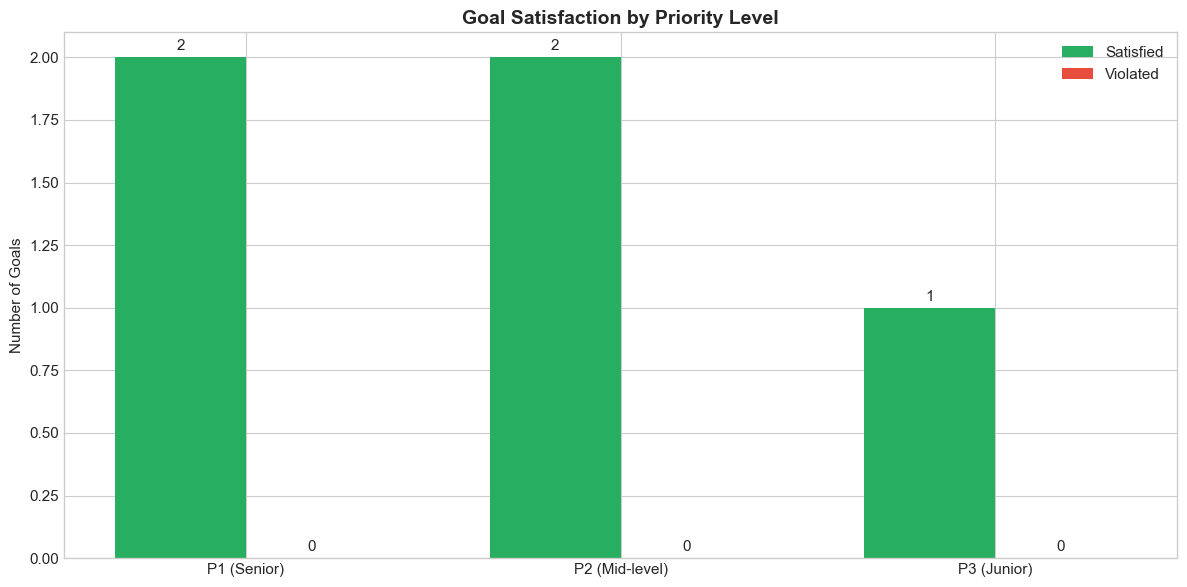


Overall: 5/5 preferences satisfied (100%)


In [10]:
# Visualize goal satisfaction
fig, ax = plt.subplots(figsize=(12, 6))

priorities = ['P1 (Senior)', 'P2 (Mid-level)', 'P3 (Junior)']
satisfied_counts = []
violated_counts = []

for p in [1, 2, 3]:
    sat = sum(1 for r in goal_results[p] if r['Satisfied'])
    viol = len(goal_results[p]) - sat
    satisfied_counts.append(sat)
    violated_counts.append(viol)

x = np.arange(len(priorities))
width = 0.35

bars1 = ax.bar(x - width/2, satisfied_counts, width, label='Satisfied', color='#27ae60')
bars2 = ax.bar(x + width/2, violated_counts, width, label='Violated', color='#e74c3c')

ax.set_ylabel('Number of Goals')
ax.set_title('Goal Satisfaction by Priority Level', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(priorities)
ax.legend()
ax.bar_label(bars1, padding=3)
ax.bar_label(bars2, padding=3)

plt.tight_layout()
plt.show()

# Summary
total_satisfied = sum(satisfied_counts)
total_goals = sum(satisfied_counts) + sum(violated_counts)
print(f"\nOverall: {total_satisfied}/{total_goals} preferences satisfied ({100*total_satisfied/total_goals:.0f}%)")

## 8. Visualize Sample Timetable

In [11]:
def create_teacher_timetable(session: Session, solution, teacher_id: int):
    """Create timetable grid highlighting preference satisfaction."""
    grid = [["" for _ in range(5)] for _ in range(6)]
    highlight = [[False for _ in range(5)] for _ in range(6)]
    
    teacher_lectures = session.query(Lecture).filter_by(teacher_id=teacher_id).all()
    lecture_ids = [l.id for l in teacher_lectures]
    
    for (lecture_id, timeslot_id, classroom_id), value in solution.variables["assignment"].items():
        if value > 0.5 and lecture_id in lecture_ids:
            lecture = session.query(Lecture).filter_by(id=lecture_id).first()
            timeslot = session.query(TimeSlot).filter_by(id=timeslot_id).first()
            classroom = session.query(Classroom).filter_by(id=classroom_id).first()
            subject = session.query(Subject).filter_by(id=lecture.subject_id).first()
            school_class = session.query(SchoolClass).filter_by(id=lecture.class_id).first()
            
            cell = f"{subject.name}\n{school_class.name}\n{classroom.name}"
            grid[timeslot.period - 1][timeslot.day_of_week] = cell
    
    return grid


def plot_timetable_with_prefs(grid, title, pref_day=None):
    """Plot timetable highlighting preference days."""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Background colors
    for i in range(6):
        for j in range(5):
            if pref_day is not None and j == pref_day:
                color = '#ffe6e6' if grid[i][j] else '#ffcccc'  # Red for preference day
            else:
                color = '#e8f4f8' if grid[i][j] else '#f5f5f5'
            ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor=color, edgecolor='gray'))
    
    # Text
    for i in range(6):
        for j in range(5):
            if grid[i][j]:
                ax.text(j, i, grid[i][j], ha='center', va='center', fontsize=9,
                       bbox=dict(boxstyle='round', facecolor='#3498db', alpha=0.7),
                       color='white', fontweight='bold')
    
    ax.set_xlim(-0.5, 4.5)
    ax.set_ylim(5.5, -0.5)
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(6))
    ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    ax.set_yticklabels([f'Period {i+1}' for i in range(6)])
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig

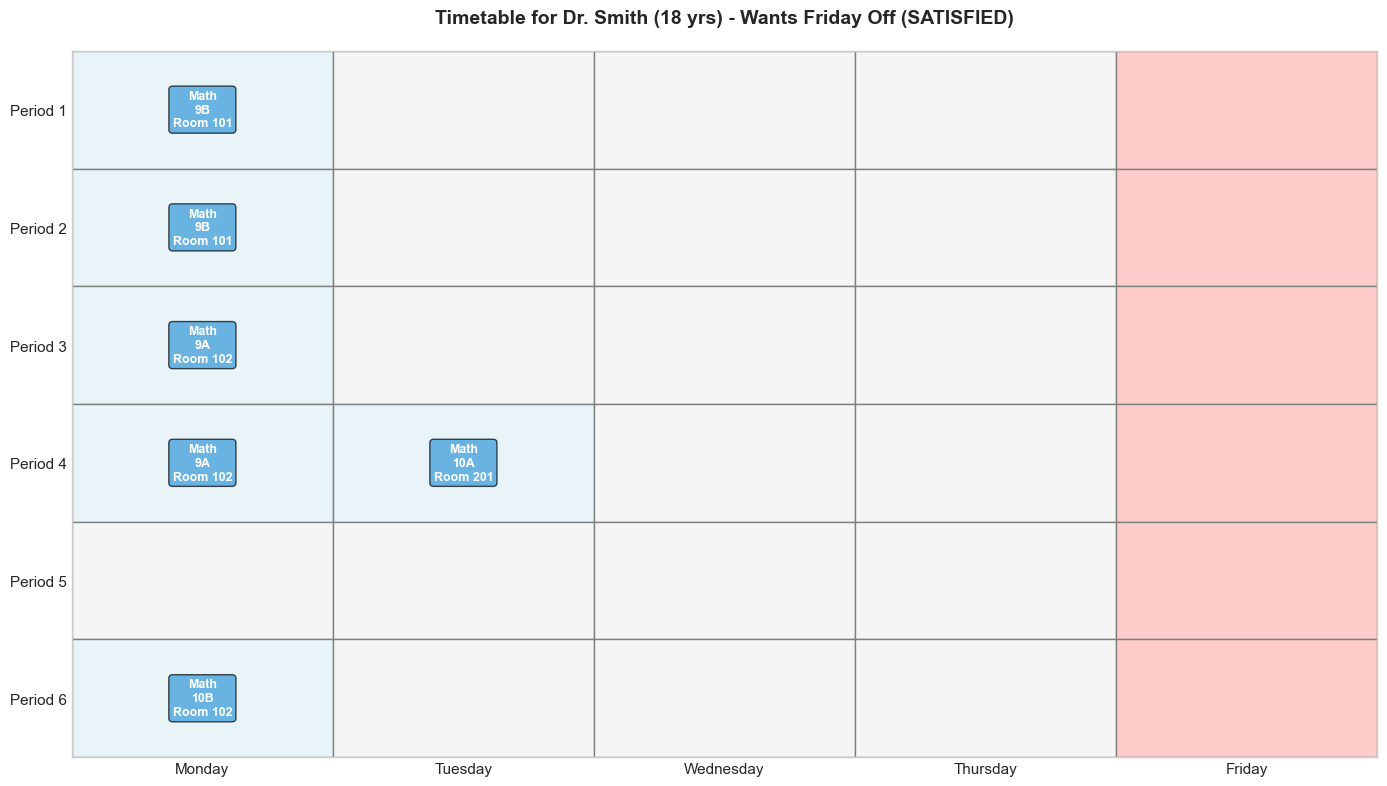

In [15]:
# Plot Dr. Smith's timetable (wants Friday off)
teacher = session.query(Teacher).filter_by(id=1).first()
grid = create_teacher_timetable(session, solution, teacher.id)

# Check Friday (day 4)
friday_lectures = sum(1 for cell in [grid[p][4] for p in range(6)] if cell)
status = "(SATISFIED)" if friday_lectures == 0 else f"(VIOLATED: {friday_lectures} lectures)"

fig = plot_timetable_with_prefs(grid, f"Timetable for {teacher.name} ({teacher.work_years} yrs) - Wants Friday Off {status}", pref_day=4)
plt.show()

## 9. Key Insights

### What We Learned

1. **Goal Programming**: Soft constraints that the optimizer tries to satisfy but doesn't require:
   ```python
   .as_goal(priority=1, weight=1.0)
   ```

2. **Priority Levels**: Goals are satisfied in priority order (P1 first, then P2, then P3). Higher-priority goals take precedence.

3. **Seniority-Based Priorities**: Map years of service to priority levels:
   - 15+ years → Priority 1
   - 7-14 years → Priority 2  
   - 0-6 years → Priority 3

4. **Goal Analysis**: Use `solution.is_goal_satisfied()` and `solution.get_goal_deviations()` to analyze results.

### Pattern: Goal Programming

```python
# Add soft constraint as goal
model.add_constraint(
    LXConstraint("goal_name")
    .expression(expr)
    .le()  # or eq(), ge()
    .rhs(target_value)
    .as_goal(priority=1, weight=1.0)  # Make it a soft constraint
)

# Enable goal programming
model.set_goal_mode("weighted")
model.prepare_goal_programming()
```

## 10. Extensions & Exercises

1. **More preference types**: EARLY_MORNING, AFTERNOON_ONLY, etc.
2. **Preference weights**: Some preferences more important than others within same priority
3. **Conflicting preferences**: Handle cases where preferences conflict
4. **Historical analysis**: Track preference satisfaction over multiple schedule versions
5. **What-if analysis**: How would satisfaction change with different priorities?

**Next notebook**: Large-scale optimization with room type constraints.

In [ ]:
# Cleanup
session.close()
print("Session closed.")